In [2]:
import pandas as pd
import matplotlib.pyplot as plt

Load and Explore the Dataset

In [3]:
#Load the dataset
df = pd.read_csv(r"C:\Users\shimb\Downloads\Dataset_Predict The Fare Amount Of Future Rides Using Regression Analysis\uber.csv")

In [4]:
#Inspect Dataset Structure
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [5]:
df.shape

(200000, 9)

In [6]:
df.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [7]:
#Check Datatypes 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [8]:
#Analyze Distribution of Target Variable (Fare Amount)
df['fare_amount'].describe

<bound method NDFrame.describe of 0          7.5
1          7.7
2         12.9
3          5.3
4         16.0
          ... 
199995     3.0
199996     7.5
199997    30.9
199998    14.5
199999    14.1
Name: fare_amount, Length: 200000, dtype: float64>

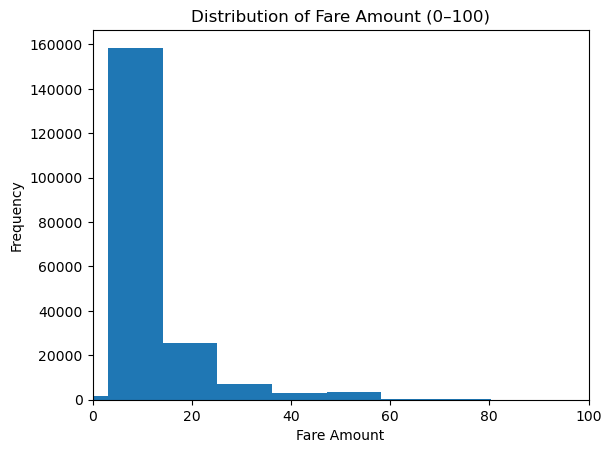

In [9]:
plt.hist(df['fare_amount'], bins=50)
plt.xlim(0, 100)   # focus on common fares
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.title("Distribution of Fare Amount (0–100)")
plt.show()

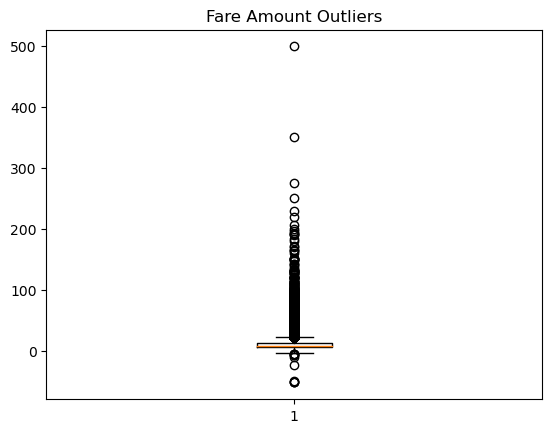

In [10]:
#Identify patterns & outliers
plt.boxplot(df['fare_amount'])
plt.title("Fare Amount Outliers")
plt.show()

In [11]:
#Passenger count pattern
df['passenger_count'].value_counts()

passenger_count
1      138425
2       29428
5       14009
3        8881
4        4276
6        4271
0         709
208         1
Name: count, dtype: int64

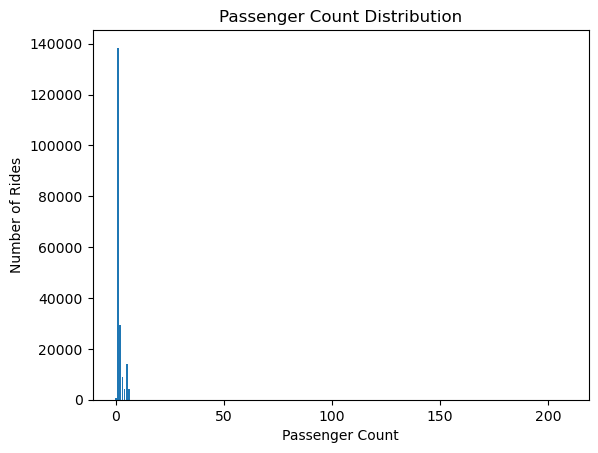

In [12]:
plt.bar(df['passenger_count'].value_counts().index,
        df['passenger_count'].value_counts().values)
plt.xlabel("Passenger Count")
plt.ylabel("Number of Rides")
plt.title("Passenger Count Distribution")
plt.show()

Handle Missing Data

In [13]:
#Identify Missing Values
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [14]:
#Check Percentage of Missing Data
(df.isnull().sum() / len(df)) * 100

Unnamed: 0           0.0000
key                  0.0000
fare_amount          0.0000
pickup_datetime      0.0000
pickup_longitude     0.0000
pickup_latitude      0.0000
dropoff_longitude    0.0005
dropoff_latitude     0.0005
passenger_count      0.0000
dtype: float64

Strategy Used for This Dataset:
Why removing rows is suitable here:
Dataset is very large
Missing values are few
Removing them won’t affect model accuracy

In [15]:
#Remove Rows with Missing Values
df = df.dropna()

In [16]:
#Verify Missing Data Is Handled
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

Feature Engineering

In [17]:
#Extract Time-Based Features
# convert to datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [18]:
# extract hour
df['hour'] = df['pickup_datetime'].dt.hour

In [19]:
df.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'hour'],
      dtype='object')

In [20]:
# create time of day feature
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'
df['time_of_day'] = df['hour'].apply(time_of_day)

In [21]:
#Create Distance Feature
import numpy as np
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c

In [22]:
df['distance_km'] = haversine(
    df['pickup_latitude'],
    df['pickup_longitude'],
    df['dropoff_latitude'],
    df['dropoff_longitude']
)

In [23]:
#Create Distance Categories
def distance_category(dist):
    if dist < 2:
        return 'Short'
    elif dist < 10:
        return 'Medium'
    else:
        return 'Long'

df['distance_category'] = df['distance_km'].apply(distance_category)

In [24]:
#Create Weekend Feature
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


In [25]:
#Select Final Features for Regression
features = [
    'distance_km',
    'passenger_count',
    'hour',
    'is_weekend'
]

Split the Dataset

In [26]:
#Target variable
y=df['fare_amount']

In [27]:
#Features
X=df[['distance_km','passenger_count','is_weekend']]

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% testing
    random_state=42     # for reproducibility
)

In [30]:
#Check Shapes
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (159999, 3)
Testing data shape: (40000, 3)


Data Scaling/Normalization

In [31]:
#Import Scalar
from sklearn.preprocessing import StandardScaler

In [32]:
#Create Scaler Object
scaler = StandardScaler()

In [33]:
#Fit Only on Training Data
X_train_scaled = scaler.fit_transform(X_train)

In [34]:
#Transform Testing Data
X_test_scaled = scaler.transform(X_test)

In [35]:
#Check Result
print(X_train_scaled[:5])

[[-4.91694720e-02 -4.87423280e-01 -6.29183347e-01]
 [-4.95244919e-02 -4.87423280e-01 -6.29183347e-01]
 [-5.08797656e-02  9.36234062e-01  1.58936184e+00]
 [-5.32854705e-02  2.24405391e-01  1.58936184e+00]
 [-2.08991915e-03  2.35989140e+00 -6.29183347e-01]]


Correlation Analysis

In [37]:
#Select Only Numeric Columns
df.corr(numeric_only=True)

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,distance_km,day_of_week,is_weekend
Unnamed: 0,1.000000,0.000587,0.000230,-0.000341,0.000270,0.000271,0.002259,0.000044,-0.000918,-0.004596,-0.003506
fare_amount,0.000587,1.000000,0.010458,-0.008482,0.008986,-0.011014,0.010158,-0.021463,0.024684,0.007508,0.000644
pickup_longitude,0.000230,0.010458,1.000000,-0.816461,0.833026,-0.846324,-0.000415,0.002432,0.105581,0.000825,-0.001935
pickup_latitude,-0.000341,-0.008482,-0.816461,1.000000,-0.774787,0.702367,-0.001559,-0.003821,-0.062436,-0.002454,0.001020
dropoff_longitude,0.000270,0.008986,0.833026,-0.774787,1.000000,-0.917010,0.000033,0.003478,0.056717,0.000001,-0.002699
dropoff_latitude,0.000271,-0.011014,-0.846324,0.702367,-0.917010,1.000000,-0.000659,-0.002544,-0.079944,-0.002335,0.000930
passenger_count,0.002259,0.010158,-0.000415,-0.001559,0.000033,-0.000659,1.000000,0.013187,-0.001472,0.033189,0.038950
hour,0.000044,-0.021463,0.002432,-0.003821,0.003478,-0.002544,0.013187,1.000000,-0.000638,-0.086956,-0.091568
distance_km,-0.000918,0.024684,0.105581,-0.062436,0.056717,-0.079944,-0.001472,-0.000638,1.000000,-0.004540,-0.002866
day_of_week,-0.004596,0.007508,0.000825,-0.002454,0.000001,-0.002335,0.033189,-0.086956,-0.004540,1.000000,0.781131


In [38]:
#View Correlation with Target Variable Only
df[['fare_amount', 'distance_km', 'passenger_count', 'hour', 'is_weekend']].corr()['fare_amount']

fare_amount        1.000000
distance_km        0.024684
passenger_count    0.010158
hour              -0.021463
is_weekend         0.000644
Name: fare_amount, dtype: float64

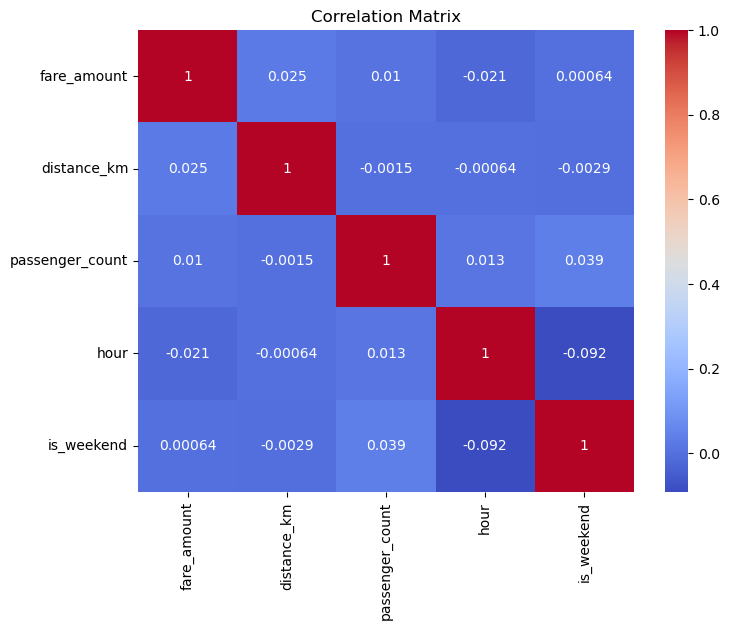

In [39]:
#Create Correlation Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(
    df[['fare_amount', 'distance_km', 'passenger_count', 'hour', 'is_weekend']].corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title("Correlation Matrix")
plt.show()